In [1]:
import warnings

warnings.filterwarnings("ignore")

# Introduction

The company provides machine learning solutions that solve problems common in the European banking market.

A particular bank offers term deposits to its customers. The bank calls customers (often multiple times a year) to get them to subscribe to a term deposit. The bank collects the following data **for each customer** from these phone calls:



*   Age (numeric)
*   Job Type (categorical)
*   Marital Status (categorical)
*   Education (categorical)
*   Has Defaulted (binary)
*   Avg. Yearly Balance (numeric)
*   Has Home Loan (binary)
*   Has Personal Loan (binary)
*   Communication Preference (categorical)
*   Last Day Contacted (numeric)
*   Last Month Contacted (categorical)
*   Last Contact Duration (numeric)
*   Times Contacted (numeric)
*   Subscribed to term deposit (binary)

The company wants to create a machine learning solution that will help the bank make the most out of this data.

**The basic goal of this project is to predict whether a customer will subscribe.**

# Understanding the Data

In [2]:
import pandas as pd
data = pd.read_csv('term-deposit-marketing-2020.csv')
data.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign   y  
0  unknown    5   may       261         1  no  
1  unknown    5   may       151         1  no  
2  unknown    5   may        76         1  no  
3  unknown    5   may        92         1  no  
4  unknown    5   may       198         1  no

In [3]:
data.shape

(40000, 14)

## Data Cleaning

Ensure there are no missing values in the data.

In [4]:
# Check for nulls using isnull()
null_counts = data.isnull().sum()
print("Null counts per column:\n", null_counts)

# Get a summary of missing values
missing_data_summary = data.isnull().sum().sort_values(ascending=False)
print("\nSummary of missing values:\n", missing_data_summary)

Null counts per column:
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

Summary of missing values:
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64


## Call Outcome Distribution

In [5]:
from collections import Counter

# Verify current imbalance
X = data.drop('y', axis=1)
y = data['y']

def class_counts(data, y):
    class_counts = Counter(y)
    total_samples = sum(class_counts.values())
    class_ratios = {cls: count / total_samples for cls, count in class_counts.items()}

    print(f'Class Counts: {class_counts}')
    print(f"Total Samples: {total_samples}")
    print(f"Class Ratios: {class_ratios}")

print("Dataset imbalance")
class_counts(data, y)

Dataset imbalance
Class Counts: Counter({'no': 37104, 'yes': 2896})
Total Samples: 40000
Class Ratios: {'no': 0.9276, 'yes': 0.0724}


Only 7% of the customers are subscribed. Bank needs to increase this number.

## Call Effort

In [6]:
def convert_seconds(seconds):
    days = seconds // 86400
    hours = (seconds % 86400) // 3600
    minutes = (seconds % 3600) // 60
    remaining_seconds = seconds % 60
    return days, hours, minutes, remaining_seconds

secs = data['duration'].sum()

print(f'Total Duration: {convert_seconds(secs)[0]} days.')

Total Duration: 117 days.


All the calls for 40,000 customers totaled 117 days.

## Analysis

The bank is spending way too much time calling customers with very little results to show for that effort. How can we maximize customer subscriptions while minimizing call time?

# Project Goals

1. Predict if a new customer will subscribe.
2. Which segments of customers are more likely to subscribe (and thus the bank should prioritize calling)?
3. What makes customers subscribe?

## Approach

We assume that the company runs our solution on new customer data, that doesn't include call-related data (duration, times called etc.). We use a multilayered approach:

1.   Train first (supervised) model on non call-related features. This model predicts which new customers the bank should initiate the call campaign with. (i.e. likely to subscribe). This addresses goal 1.
2.   Train second (supervised) model on all the features for the customers predicted by first model. This model predicts which customers to keep on calling. This addresses goals 1 and 2.

*   Run first model on all the original data, get predicted yes customers.
*   Second model dataset: predicted yes customers from first model, with their feature values from the original dataset. Some of the true labels will be no.
*   Train second model on this new dataset. Success of second model is whether the predictions match the labels.


3.   Train third (unsupervised) model on all subscribing customers to determine distinct groups of subscribing customers. This allows the bank to know who their customers are. We don't have cause/effect data for customer actions of subscribing, so we can't directly answer what makes customers subscribe.








## Measures of Success

The challenge is a highly imbalanced dataset, where the majority class is **no**.

### Model 1

*   High Recall: Need to identify people who are actually subscribing. What percentage of customers can we eliminate?

### Model 2

*   High Precision: We don't want to keep calling people unlikely to subscribe. What percentage of customers can we eliminate?

### Model 3



*   Determine patterns within the subscribing customers.

# Model 1



*   Which customers should bank initiate call campaign with?
*   What percentage of customers can we eliminate?



## Exploratory Data Analysis

In [7]:
# Drop call-related features
data_init = data.drop(['contact', 'day', 'month', 'duration', 'campaign'], axis=1)
data_init.head()

age           job  marital  education default  balance housing loan   y
0   58    management  married   tertiary      no     2143     yes   no  no
1   44    technician   single  secondary      no       29     yes   no  no
2   33  entrepreneur  married  secondary      no        2     yes  yes  no
3   47   blue-collar  married    unknown      no     1506     yes   no  no
4   33       unknown   single    unknown      no        1      no   no  no

## Class Distinction with Numerical Features

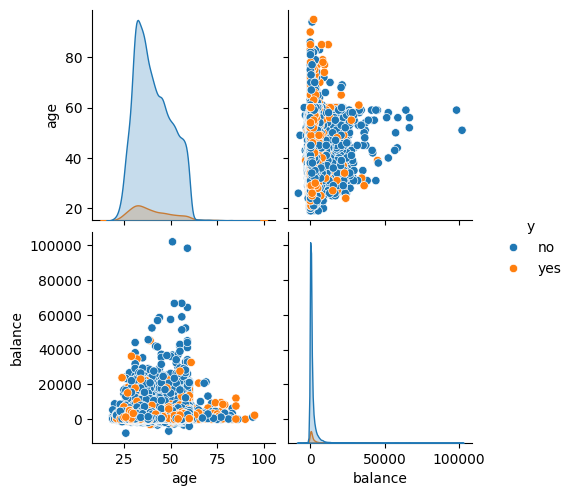

In [8]:
numerical_features = ['age', 'balance']

import seaborn as sns
import matplotlib.pyplot as plt

# Pair plot for numerical features
sns.pairplot(data_init, hue='y', vars=numerical_features)
plt.show()

Observations:



*   Above a certain balance, yes classes become rare/non-existent. Balance could be a useful feature to separate the classes
*   Yes and no classes span pretty much all ages.



## Class Distinction with Binary/Categorical Features

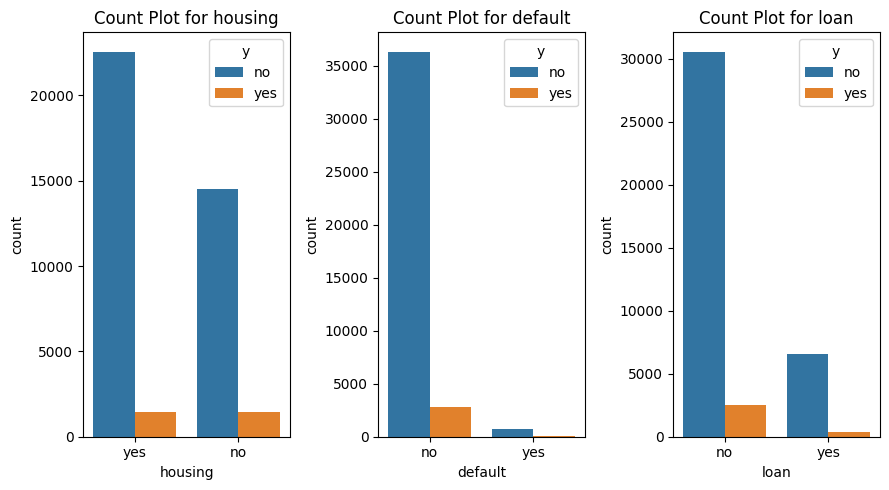

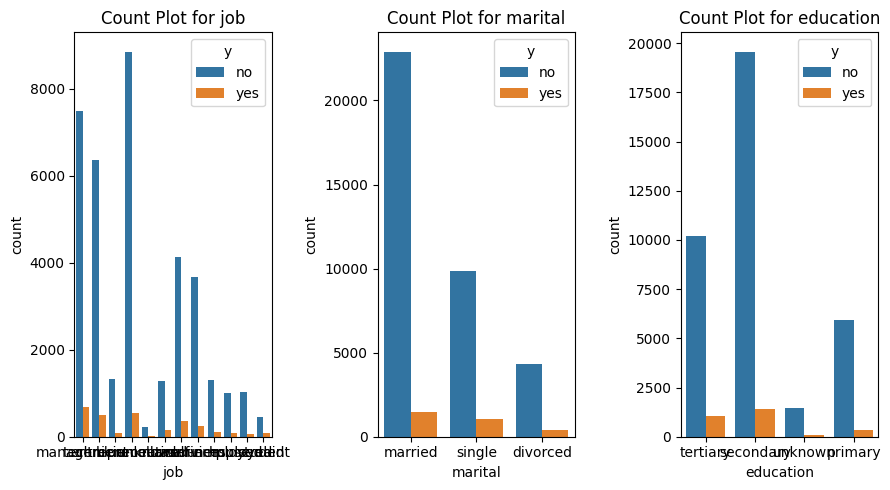

In [9]:
binary_features = ['housing', 'default', 'loan']
categorical_features = ['job', 'marital', 'education']

def column_plot(data, features):
  # Calculate appropriate figure size
  fig_width = len(features) * 3  # Adjust the multiplier as needed for better spacing
  fig_height = 5
  fig, axes = plt.subplots(1, len(features), figsize=(fig_width, fig_height))

  for i, column in enumerate(features):
      sns.countplot(x=column, hue='y', data=data, ax=axes[i])
      axes[i].set_title(f'Count Plot for {column}')

  plt.tight_layout()
  plt.show()

# binary_features
column_plot(data=data_init, features=binary_features)

# categorical features
column_plot(data=data_init, features=categorical_features)

Observations:


*   All categories for all features have severe imbalance between no and yes. No clearly trumps yes.
*   These features don't give any useful information on whether a customer will subscribe.




## Preprocessing

In [10]:
from sklearn.preprocessing import StandardScaler
def preprocess(data, binary_features, numerical_features, categorical_features):
  # Convert binary features from 'no'/'yes' to False/True
  data[binary_features] = data[binary_features].applymap(lambda x: True if x == 'yes' else False)

  # Standardize numerical features
  scaler = StandardScaler()
  data[numerical_features] = scaler.fit_transform(data[numerical_features])

  # One-hot encode categorical features
  data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

  return data

binary_features.append('y')
data_init = preprocess(data=data_init, binary_features=binary_features, numerical_features=numerical_features, categorical_features=categorical_features)
data_init.head()

age  default   balance  housing   loan      y  job_blue-collar  \
0  1.810415    False  0.299174     True  False  False            False   
1  0.358382    False -0.428854     True  False  False            False   
2 -0.782501    False -0.438152     True   True  False            False   
3  0.669532    False  0.079802     True  False  False             True   
4 -0.782501    False -0.438497    False  False  False            False   

   job_entrepreneur  job_housemaid  job_management  ...  job_services  \
0             False          False            True  ...         False   
1             False          False           False  ...         False   
2              True          False           False  ...         False   
3             False          False           False  ...         False   
4             False          False           False  ...         False   

   job_student  job_technician  job_unemployed  job_unknown  marital_married  \
0        False           False           False        False             True   
1        False            True           False        False            False   
2        False           False           False        False             True   
3        False           False           False        False             True   
4        False           False           False         True            False   

   marital_single  education_secondary  education_tertiary  education_unknown  
0           False                False                True              False  
1            True                 True               False              False  
2           False                 True               False              False  
3           False                False               False               True  
4            True                False               False               True  

[5 rows x 22 columns]

## Feature Importance



*   Possible with all features, there is too much class overlap to meaningfully distingiush.
*   Feature importance can determine which features meaningfully contribute to a class distinction.



In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Prepare the data
X = data_init.drop('y', axis=1)
y = data_init['y']

def run_predict(model, X, y, undersample=False, method="predict"):
  # Initialize stratified k-fold
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  # Create a pipeline
  steps = []
  if undersample:
      steps.append(('undersampler', RandomUnderSampler(random_state=42)))
  steps.append(('model', model))

  pipeline = Pipeline(steps)

  # Perform cross-validation prediction
  return pipeline, cross_val_predict(pipeline, X, y, cv=skf, method=method)

# Define the model
# heuristic min_samples_leaf=10 to prevent overfiting
clf = RandomForestClassifier(random_state=42, min_samples_leaf=10)

# Perform cross-validation and get predictions
pipeline, y_pred = run_predict(clf, X, y, undersample=True)

# Evaluate the model
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

       False       0.95      0.61      0.74     37104
        True       0.10      0.57      0.17      2896

    accuracy                           0.60     40000
   macro avg       0.52      0.59      0.46     40000
weighted avg       0.89      0.60      0.70     40000



Observations:


*   Accuracy and True recall numbers are evidence of huge overlapping of classes across all features.



In [12]:
# Fit the model to the entire dataset to get feature importances
pipeline.fit(X, y)
feature_importances = pipeline.named_steps['model'].feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance
features_df = features_df.sort_values(by='Importance', ascending=False)
features_df

Feature  Importance
2               balance    0.328786
0                   age    0.257455
3               housing    0.062317
16      marital_married    0.059995
4                  loan    0.046465
19   education_tertiary    0.043326
17       marital_single    0.041265
18  education_secondary    0.026035
5       job_blue-collar    0.022530
13       job_technician    0.018186
8        job_management    0.017786
11         job_services    0.016522
9           job_retired    0.013578
12          job_student    0.010468
10    job_self-employed    0.008974
14       job_unemployed    0.006537
7         job_housemaid    0.006314
20    education_unknown    0.006253
6      job_entrepreneur    0.005053
1               default    0.001852
15          job_unknown    0.000304

Observations:


*   Balance and age significantly more important/influential than rest of features for distinguishing the classes.
*   Can we achieve similar accuracy/recall numbers using just balance and age?



In [13]:
# Prepare the data
data_important = data_init[['balance', 'age', 'y']]
X_important = data_important[['balance', 'age']]
y_important = data_important['y']

# Define the model
# heuristic min_samples_leaf=10 to prevent overfiting
clf = RandomForestClassifier(random_state=42, min_samples_leaf=10)

# Perform cross-validation and get predictions
pipeline, y_pred = run_predict(clf, X_important, y_important, undersample=True)

# Evaluate the model
print(classification_report(y_important, y_pred))

              precision    recall  f1-score   support

       False       0.94      0.58      0.71     37104
        True       0.09      0.53      0.15      2896

    accuracy                           0.57     40000
   macro avg       0.51      0.55      0.43     40000
weighted avg       0.88      0.57      0.67     40000



Observations:


*   Not that much worse accuracy/recall
*   Eliminate all features but balance and age.



## Class Distinction with Most Important Features

Balance and Age (numerical features)

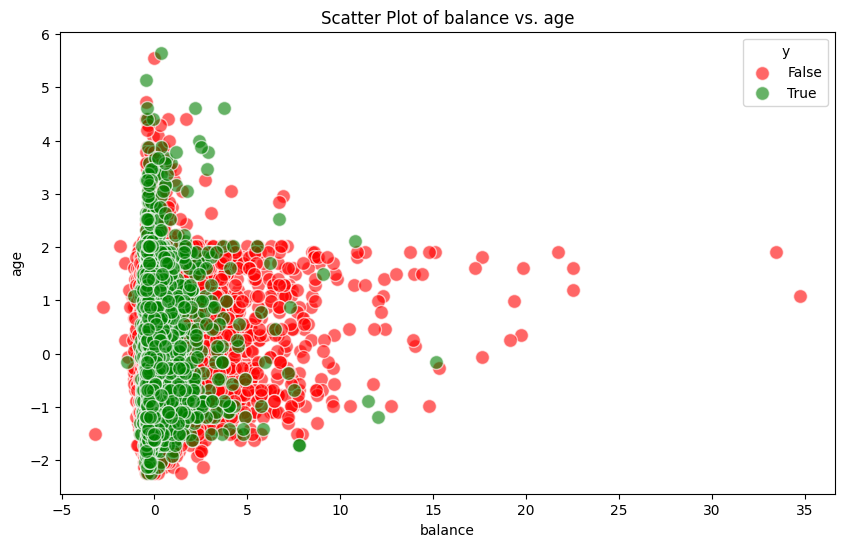

In [14]:
def scatter_plot(data, feature1, feature2, label):
  colors = {True: 'green', False: 'red'}

  plt.figure(figsize=(10, 6))

  # Plot False points first (red)
  subset_false = data[~data[label]]
  plt.scatter(subset_false[feature1], subset_false[feature2], c=colors[False], label='False', alpha=0.6, edgecolors='w', s=100)

  # Plot True points on top (green)
  subset_true = data[data[label]]
  plt.scatter(subset_true[feature1], subset_true[feature2], c=colors[True], label='True', alpha=0.6, edgecolors='w', s=100)

  # Set labels and title
  plt.xlabel(feature1)
  plt.ylabel(feature2)
  plt.title(f'Scatter Plot of {feature1} vs. {feature2}')

  # Add legend
  plt.legend(title=label)

scatter_plot(data=data_important, feature1='balance', feature2='age', label='y')

Observations:


*   Yes class rare when Balance >= 5 and Balance <= slightly above -1
*   Lots of overlap, no obvious places where there are only yes classes



## The Maybe Approach



*   Clear regions with mostly/solely nos, but no clear regions with mostly/solely yes.
*   Treat overlapping class points as "maybes", and the rest of the points as nos.
* Train model to classify nos and maybes.
* Business Justification: maybes are a good indication of who to add to the initial call list, and allow us to eliminate customers who are likely to be a no.
* Track how many maybes are really yes. Because if most of the true yes classes are captured in the maybe class, the bank has confidence they are targeting the right people.



### Identifying Maybes

We need to have a good overlap condition to reclassify points as either no or maybe. The true overlap condition is if a point is equal to any yes point, and if so, classify as maybe. Inherently, all yes points are classified as maybes.




In [15]:
# Identify the unique (balance, age) pairs where y is True
true_pairs = data_important[data_important['y']][['balance', 'age']].drop_duplicates()

# Merge data_important with true_pairs on balance and age to filter rows
data_reclassified = pd.merge(data_important, true_pairs, on=['balance', 'age'])
data_reclassified.shape

(7186, 3)

It looks like there are no y=False points that have the exact same balance/age values as y=True points.

Visually, there looks like y=False and y=True points are super close. Let's use a threshold of k, meaning that the euclidian distance between a point and a y=True point should be at most k for it to be reclassified as maybe.

It's ok to use a k threshold because balance and age are already standardized.

We can try different ks to see how many definite nos we get.

In [16]:
import numpy as np

def get_distances(data, features, label):
    """
    Compute the shortest Euclidean distance from each point in the dataset
    to any point where the label is True.

    Parameters:
    - data: DataFrame containing the dataset
    - features: List of feature column names to be used for distance computation
    - label: Column name for the boolean label indicating points of interest

    Returns:
    - A tuple containing:
      - A NumPy array with shape (n_points, m_points), where each entry (i, j) is the distance
        between the i-th point in the dataset and the j-th point where the label is True.
      - A NumPy array of shape (n_points,) where each entry is the shortest distance from that point
        to any point with the label True.
    """
    # Identify points where label is True
    true_points = data[data[label]][features].values

    # Extract feature columns as a NumPy array for all points
    all_points = data[features].values

    # Compute the Euclidean distances
    distances = np.sqrt(((all_points[:, np.newaxis, :] - true_points[np.newaxis, :, :])**2).sum(axis=2))

    return np.min(distances, axis=1)


In [17]:
def reclassify_data(data, distances, k, features, label):
    """
    Reclassify data points based on whether any true point is within the distance k.

    Parameters:
    - data: DataFrame containing the dataset with features and label
    - distances: NumPy array of shape (n_points, ), where each entry is the shortest distance
      from that point to any point with the label True.
    - k: Distance threshold for reclassification
    - features: List of feature column names used for distance computation
    - label: Column name for the boolean label indicating points of interest

    Returns:
    - A DataFrame with reclassified labels based on distance criteria
    """
    # Check if any true point is within k distance for each point
    within_threshold = distances <= k

    # Create the data_reclassified dataframe
    data_reclassified = data[features].copy()
    data_reclassified[label] = within_threshold

    return data_reclassified

In [18]:
# Initialize an empty list to store the counts for each k
counts_list = []

distances = get_distances(data_important, ['balance', 'age'], 'y')

for k in np.arange(0, 0.15, 0.01):
  counts = reclassify_data(data_important, distances, k, ['balance', 'age'], 'maybe')['maybe'].value_counts()

  # Append counts to the list with the value of k
  counts_list.append({'k': k, 'maybe': counts.get(True, 0), 'no': counts.get(False, 0)})

# Convert the list to a dataframe
counts_df = pd.DataFrame(counts_list)
counts_df

k  maybe     no
0   0.00   7186  32814
1   0.01  27812  12188
2   0.02  32257   7743
3   0.03  34163   5837
4   0.04  35350   4650
5   0.05  36045   3955
6   0.06  36550   3450
7   0.07  36929   3071
8   0.08  37267   2733
9   0.09  37527   2473
10  0.10  37730   2270
11  0.11  38498   1502
12  0.12  38785   1215
13  0.13  38900   1100
14  0.14  39002    998

k = 0 does not make any sense, since all the points are distinct even at the most granular level. Let's use k = 0.01, as it maximizes the number of definite nos. We can go even more granular (e.g. k = 0.05) to increase the number of definite nos. However, let's not do that because 0.01 is a very negligible difference.

k > 0.01 drastically decreases the number of definite nos.

### Reclassified Plot

In [19]:
data_reclassified = reclassify_data(data=data_important, distances=distances, k=0.01, features=['balance', 'age'], label='maybe')
data_reclassified.head()

balance       age  maybe
0  0.299174  1.810415   True
1 -0.428854  0.358382   True
2 -0.438152 -0.782501   True
3  0.079802  0.669532  False
4 -0.438497 -0.782501   True

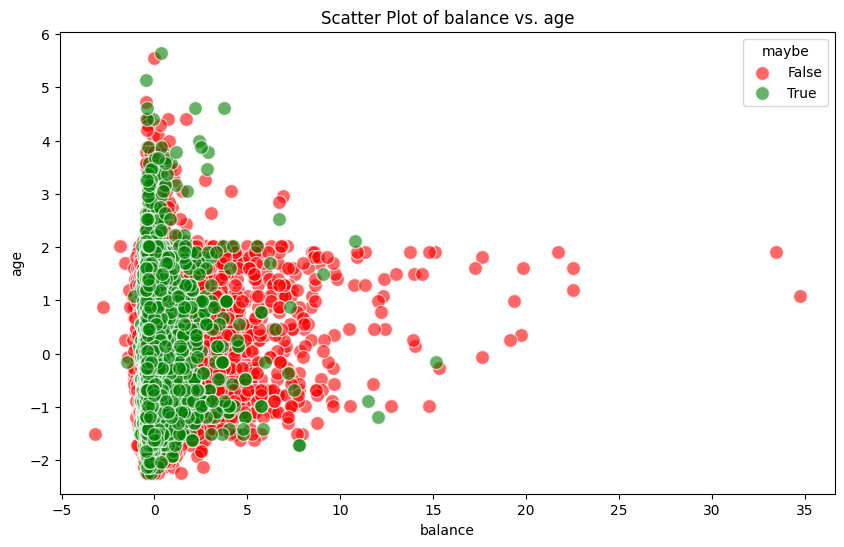

In [20]:
scatter_plot(data=data_reclassified, feature1='balance', feature2='age', label='maybe')

In [21]:
class_counts(data=data_reclassified, y=data_reclassified['maybe'])

Class Counts: Counter({True: 27812, False: 12188})
Total Samples: 40000
Class Ratios: {True: 0.6953, False: 0.3047}


12,188 points are definite nos. That's over 30% of the customers we can exclude from the initial call list.

## Models to Try

The scatter plot has a huge section of maybes surrounding balance = 0, and the rest of the plot is mostly reds. There are a three models that are suitable for this kind of data:



*   Logistic Regression: the green area kind of looks like an ellipse, so if we square the features, we can train the model to fit an elliptical decision boundary.
*   Random Forest: generally works well for binary classification problems
* Neural Network: can possibly fit a better decision boundary than an ellipse.

In addition to high recall, we want high accuracy because we already reclassified a bunch of nos as maybes. High precision is nice, as it reduces misclassification of nos as maybes. However, it's not as high of a priority as the other two, because the goal is to not miss out on potential customers.

Finally, there is no longer a major imbalance between the two classes. Undersampling/oversampling may not be needed.



In [22]:
# original data, make sure nothing was messed up
data_important.head()

balance       age      y
0  0.299174  1.810415  False
1 -0.428854  0.358382  False
2 -0.438152 -0.782501  False
3  0.079802  0.669532  False
4 -0.438497 -0.782501  False

In [23]:
# dataset to train/test:
X_re = data_reclassified[['balance', 'age']]
y_re = data_reclassified['maybe']

In [24]:
from sklearn.linear_model import LogisticRegression
pipeline, y_pred = run_predict(LogisticRegression(random_state=42), X_re, y_re)
print(classification_report(y_re, y_pred))

              precision    recall  f1-score   support

       False       0.77      0.35      0.48     12188
        True       0.77      0.96      0.85     27812

    accuracy                           0.77     40000
   macro avg       0.77      0.65      0.67     40000
weighted avg       0.77      0.77      0.74     40000



In [25]:
pipeline, y_pred = run_predict(RandomForestClassifier(random_state=42, min_samples_leaf=10), X_re, y_re)
print(classification_report(y_re, y_pred))

              precision    recall  f1-score   support

       False       0.84      0.87      0.86     12188
        True       0.94      0.93      0.94     27812

    accuracy                           0.91     40000
   macro avg       0.89      0.90      0.90     40000
weighted avg       0.91      0.91      0.91     40000



Random Forest results are strong for all metrics. We can confirm the model is valuable by ensuring that the maybe predictions contain most of the true labels (i.e. high recall).

In [26]:
print(classification_report(y_important, y_pred))

              precision    recall  f1-score   support

       False       0.95      0.32      0.48     37104
        True       0.08      0.77      0.15      2896

    accuracy                           0.35     40000
   macro avg       0.51      0.54      0.31     40000
weighted avg       0.88      0.35      0.46     40000



True recall is good. False recall is bad, but doesn't matter, because inherently many of the true no customers are maybes. Alhtough accuracy and precision are bad, those metrics don't matter, because maybes aren't the same as yes predictions.

There is no point in trying a neural network.

## Summary

To determine which customers from brand new data to add to the initial call campaign, the bank needs to:



1.   Drop all features except balance and age.
2.   Standardize and reclassify each point as a no or maybe, using a maximum 0.01 distance from any point to a yes point to reclassify as maybe.
3. Train a random forest with min_samples_leaf=10 on the reclassified data.

The business value of Model 1 is that it reduces the number of customers to initiate the call campaign by over 30%. This saves the call center many hours of time, while still targeting customers who are likely to subscribe.



# Model 2



*   Of the customers outputted by Model 1, which ones should bank continually call? This means that the customer information outputted by Model 1 is the dataset for Model 2.
* A change from the original design is that Model 1 outputs maybes, not yesses.
* Train models on all features, and measure of success is how well the predicted labels match the original labels for the customers outputted by Model 1.
* The "yes" predictions are the customers that should be continually called.


In [27]:
# make sure original data is not messed up
data.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign   y  
0  unknown    5   may       261         1  no  
1  unknown    5   may       151         1  no  
2  unknown    5   may        76         1  no  
3  unknown    5   may        92         1  no  
4  unknown    5   may       198         1  no

## Preprocess Data

First, convert month/day to day of year (assuming year is 2024) for clean numerical values.

In [28]:
from datetime import datetime

# Month name to number mapping (lowercase keys)
month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

# Replace month names with their numeric equivalents (case insensitive)
data['month'] = data['month'].apply(lambda x: month_map.get(str(x).lower(), x))

# Convert 'day' and 'month' to integers
data['day'] = data['day'].astype(int)
data['month'] = data['month'].astype(int)

# Combine 'day' and 'month' into a datetime object -- 2024 is arbitrary
data['date'] = data.apply(lambda row: datetime(2024, row['month'], row['day']), axis=1)

# Extract the day of the year
data['day_of_year'] = data['date'].dt.dayofyear

# Drop the 'day', 'month', and 'date' columns
data.drop(columns=['day', 'month', 'date'], inplace=True)

data.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  duration  campaign   y  day_of_year  
0  unknown       261         1  no          126  
1  unknown       151         1  no          126  
2  unknown        76         1  no          126  
3  unknown        92         1  no          126  
4  unknown       198         1  no          126

In [29]:
print(f'Binary Features: {binary_features}')
print(f'Categorical Features: {categorical_features}')
print(f'Numerical Features: {numerical_features}')

Binary Features: ['housing', 'default', 'loan', 'y']
Categorical Features: ['job', 'marital', 'education']
Numerical Features: ['age', 'balance']


In [30]:
categorical_features.append('contact')
numerical_features.extend(['duration', 'campaign', 'day_of_year'])

print(f'Binary Features: {binary_features}')
print(f'Categorical Features: {categorical_features}')
print(f'Numerical Features: {numerical_features}')

Binary Features: ['housing', 'default', 'loan', 'y']
Categorical Features: ['job', 'marital', 'education', 'contact']
Numerical Features: ['age', 'balance', 'duration', 'campaign', 'day_of_year']


In [31]:
data_preprocessed = preprocess(data=data.copy(), binary_features=binary_features, numerical_features=numerical_features, categorical_features=categorical_features)
data_preprocessed.head()

age  default   balance  housing   loan  duration  campaign      y  \
0  1.810415    False  0.299174     True  False  0.023811 -0.581096  False   
1  0.358382    False -0.428854     True  False -0.400305 -0.581096  False   
2 -0.782501    False -0.438152     True   True -0.689474 -0.581096  False   
3  0.669532    False  0.079802     True  False -0.627785 -0.581096  False   
4 -0.782501    False -0.438497    False  False -0.219092 -0.581096  False   

   day_of_year  job_blue-collar  ...  job_technician  job_unemployed  \
0    -0.587198            False  ...           False           False   
1    -0.587198            False  ...            True           False   
2    -0.587198            False  ...           False           False   
3    -0.587198             True  ...           False           False   
4    -0.587198            False  ...           False           False   

   job_unknown  marital_married  marital_single  education_secondary  \
0        False             True           False                False   
1        False            False            True                 True   
2        False             True           False                 True   
3        False             True           False                False   
4         True            False            True                False   

   education_tertiary  education_unknown  contact_telephone  contact_unknown  
0                True              False              False             True  
1               False              False              False             True  
2               False              False              False             True  
3               False               True              False             True  
4               False               True              False             True  

[5 rows x 27 columns]

## Use Model 1



*   Get Initial Set of customers to call



In [32]:
# Drop non-numerical features
data_m1 = data_preprocessed[['age', 'balance', 'y']]
data_m1.head()

age   balance      y
0  1.810415  0.299174  False
1  0.358382 -0.428854  False
2 -0.782501 -0.438152  False
3  0.669532  0.079802  False
4 -0.782501 -0.438497  False

In [33]:
diff = get_distances(data=data_m1, features=['balance', 'age'], label='y')
data_reclf = reclassify_data(data=data_m1, distances=diff, k=0.01, features=['balance', 'age'], label='maybe')
data_reclf.head()

balance       age  maybe
0  0.299174  1.810415   True
1 -0.428854  0.358382   True
2 -0.438152 -0.782501   True
3  0.079802  0.669532  False
4 -0.438497 -0.782501   True

In [34]:
# train and run RF on all of data_reclf
rf_clf = RandomForestClassifier(random_state=42, min_samples_leaf=10)
rf_clf.fit(data_reclf[['balance', 'age']], data_reclf['maybe'])
data_m1['maybe'] = rf_clf.predict(data_m1[['balance', 'age']])
data_m1.head()

age   balance      y  maybe
0  1.810415  0.299174  False   True
1  0.358382 -0.428854  False   True
2 -0.782501 -0.438152  False   True
3  0.669532  0.079802  False  False
4 -0.782501 -0.438497  False   True

In [35]:
# get all predicted maybe customers (some true labels will be no (False))
maybe_customers = data_m1[data_m1['maybe']]
maybe_customers.head()

age   balance      y  maybe
0  1.810415  0.299174  False   True
1  0.358382 -0.428854  False   True
2 -0.782501 -0.438152  False   True
4 -0.782501 -0.438497  False   True
5 -0.575067 -0.359288  False   True

In [36]:
maybe_idx = maybe_customers.index
data_m2 = data_preprocessed.loc[maybe_idx]
data_m2.head()

age  default   balance  housing   loan  duration  campaign      y  \
0  1.810415    False  0.299174     True  False  0.023811 -0.581096  False   
1  0.358382    False -0.428854     True  False -0.400305 -0.581096  False   
2 -0.782501    False -0.438152     True   True -0.689474 -0.581096  False   
4 -0.782501    False -0.438497    False  False -0.219092 -0.581096  False   
5 -0.575067    False -0.359288     True  False -0.446572 -0.581096  False   

   day_of_year  job_blue-collar  ...  job_technician  job_unemployed  \
0    -0.587198            False  ...           False           False   
1    -0.587198            False  ...            True           False   
2    -0.587198            False  ...           False           False   
4    -0.587198            False  ...           False           False   
5    -0.587198            False  ...           False           False   

   job_unknown  marital_married  marital_single  education_secondary  \
0        False             True           False                False   
1        False            False            True                 True   
2        False             True           False                 True   
4         True            False            True                False   
5        False             True           False                False   

   education_tertiary  education_unknown  contact_telephone  contact_unknown  
0                True              False              False             True  
1               False              False              False             True  
2               False              False              False             True  
4               False               True              False             True  
5                True              False              False             True  

[5 rows x 27 columns]

In [37]:
data_m2['maybe'] = maybe_customers['maybe']
data_m2.head()

age  default   balance  housing   loan  duration  campaign      y  \
0  1.810415    False  0.299174     True  False  0.023811 -0.581096  False   
1  0.358382    False -0.428854     True  False -0.400305 -0.581096  False   
2 -0.782501    False -0.438152     True   True -0.689474 -0.581096  False   
4 -0.782501    False -0.438497    False  False -0.219092 -0.581096  False   
5 -0.575067    False -0.359288     True  False -0.446572 -0.581096  False   

   day_of_year  job_blue-collar  ...  job_unemployed  job_unknown  \
0    -0.587198            False  ...           False        False   
1    -0.587198            False  ...           False        False   
2    -0.587198            False  ...           False        False   
4    -0.587198            False  ...           False         True   
5    -0.587198            False  ...           False        False   

   marital_married  marital_single  education_secondary  education_tertiary  \
0             True           False                False                True   
1            False            True                 True               False   
2             True           False                 True               False   
4            False            True                False               False   
5             True           False                False                True   

   education_unknown  contact_telephone  contact_unknown  maybe  
0              False              False             True   True  
1              False              False             True   True  
2              False              False             True   True  
4               True              False             True   True  
5              False              False             True   True  

[5 rows x 28 columns]

## Exploratory Data Analysis

About 30% of the original customers were eliminated. Let's first check if there's any imbalance in this new dataset (where maybe=True for all entries). After all, we're trying to predict which maybe customers to keep on calling.

In [38]:
class_counts(data=data_m2, y=data_m2['y'])

Class Counts: Counter({False: 24905, True: 2336})
Total Samples: 27241
Class Ratios: {False: 0.9142469072354172, True: 0.0857530927645828}


In [39]:
# make sure data_m2 only has maybe customers
class_counts(data=data_m2, y=data_m2['maybe'])

Class Counts: Counter({True: 27241})
Total Samples: 27241
Class Ratios: {True: 1.0}


Observations:

*   Still huge imbalance, but better than original data set.
*   2336/2896 of the original yes customers are in this new dataset.
*   24905/37104 of the original no customers are in this data set
* Model 1 did excellent job filtering out lots of no customers and retaining many yes customers.



## Feature Importance

In [40]:
X_m2 = data_m2.drop('y', axis=1)
y_m2 = data_m2['y']

pipeline, y_pred = run_predict(RandomForestClassifier(random_state=42, min_samples_leaf=10), X_m2, y_m2)

# Evaluate the model
print(classification_report(y_m2, y_pred))

              precision    recall  f1-score   support

       False       0.94      0.99      0.96     24905
        True       0.67      0.31      0.42      2336

    accuracy                           0.93     27241
   macro avg       0.80      0.65      0.69     27241
weighted avg       0.92      0.93      0.92     27241



In [41]:
# Fit the model to the entire dataset to get feature importances
pipeline.fit(X_m2, y_m2)
feature_importances = pipeline.named_steps['model'].feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({
    'Feature': X_m2.columns,
    'Importance': feature_importances
})

# Sort features by importance
features_df = features_df.sort_values(by='Importance', ascending=False)
features_df

Feature  Importance
5              duration    0.647275
7           day_of_year    0.121703
2               balance    0.073285
0                   age    0.052883
6              campaign    0.018289
3               housing    0.017508
25      contact_unknown    0.015658
19      marital_married    0.008622
22   education_tertiary    0.006537
8       job_blue-collar    0.004905
21  education_secondary    0.004779
20       marital_single    0.004700
11       job_management    0.004204
4                  loan    0.004143
16       job_technician    0.003851
24    contact_telephone    0.002173
14         job_services    0.001968
12          job_retired    0.001678
15          job_student    0.001587
23    education_unknown    0.000923
13    job_self-employed    0.000896
17       job_unemployed    0.000860
10        job_housemaid    0.000653
9      job_entrepreneur    0.000598
1               default    0.000256
18          job_unknown    0.000068
26                maybe    0.000000

Observations:



*   Duration is significantly more important than the other features. day_of_year comes in second place, albeit far behind


Can we achieve similar results using just duration, or (duration, day_of_year)?



In [42]:
# Prepare the data -- Duration Only
data_important = data_m2[['duration', 'y']]
X_important = data_important[['duration']]
y_important = data_important['y']

# Define the model
# heuristic min_samples_leaf=10 to prevent overfiting
clf = RandomForestClassifier(random_state=42, min_samples_leaf=10)

# Perform cross-validation and get predictions
pipeline, y_pred = run_predict(clf, X_important, y_important, undersample=True)

# Evaluate the model
print(classification_report(y_important, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.83      0.90     24905
        True       0.29      0.76      0.42      2336

    accuracy                           0.82     27241
   macro avg       0.63      0.79      0.66     27241
weighted avg       0.92      0.82      0.86     27241



In [43]:
# Prepare the data -- Duration and Day of YearOnly
data_important = data_m2[['duration', 'day_of_year', 'y']]
X_important = data_important.drop('y', axis=1)
y_important = data_important['y']

# Define the model
# heuristic min_samples_leaf=10 to prevent overfiting
clf = RandomForestClassifier(random_state=42, min_samples_leaf=10)

# Perform cross-validation and get predictions
pipeline, y_pred = run_predict(clf, X_important, y_important, undersample=True)

# Evaluate the model
print(classification_report(y_important, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.84      0.91     24905
        True       0.34      0.89      0.50      2336

    accuracy                           0.84     27241
   macro avg       0.67      0.86      0.70     27241
weighted avg       0.93      0.84      0.87     27241



As we add more important features, the recall and precision improves, while maintaining good accuracy. However, 34% precision is too low. A high false positive rate means the bank will call customers that in reality may not subscribe. We want a model that has high accuracy, precision and recall.

Let's look at the class separation for these features.

## Analyzing Important Features

duration and day_of_year

In [44]:
scatter_plot(data=data_important, feature1='duration', feature2='day_of_year', label='y')

Observations:


*   Longer duration gives more yes customer.
*   Season has some impact. As we get to middle of range for day of year, longer duration tends to be necessary for a yes customer.
*   Potential for good decision boundary.
* Need to check for level of overlap (i.e. maybe customers). Similar approach as in model 1, but this time, for customers to KEEP ON CALLING.



In [45]:
diff = get_distances(data=data_important, features=['duration', 'day_of_year'], label='y')
data_reclassified = reclassify_data(data=data_important, distances=diff, k=0, features=['duration', 'day_of_year'], label='maybe')
data_reclassified['maybe'].value_counts()

maybe
False    24699
True      2542
Name: count, dtype: int64

Observations:


*   Before reclassification: 24905 no customers, 2336 yes customers
* After reclassification: 24699 no customers, 2542 maybe customers
* Only 206 no customers were reclassified (k = 0), so barely any overlap. There likely exists a good decision boundary.



In [46]:
# Identify points that were reclassified from no to maybe
data_important['reclassified'] = data_reclassified['maybe']
reclassified_from_no_to_maybe = data_important[(~data_important['y']) & (data_important['reclassified'])]
reclassified_from_no_to_maybe.shape

(206, 4)

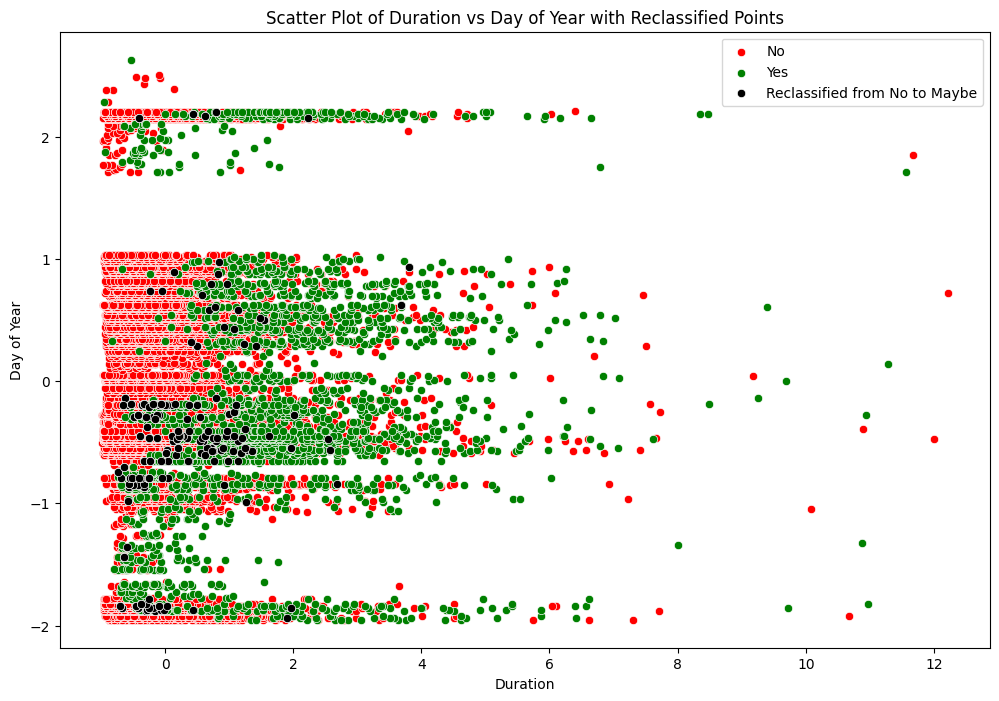

In [47]:
# Plotting
plt.figure(figsize=(12, 8))

# Plot y=False points in red
sns.scatterplot(x='duration', y='day_of_year', data=data_important[data_important['y'] == False], color='red', label='No')

# Plot y=True points in green, on top of red
sns.scatterplot(x='duration', y='day_of_year', data=data_important[data_important['y'] == True], color='green', label='Yes')

# Plot reclassified points in black, on top of green and red
sns.scatterplot(x='duration', y='day_of_year', data=reclassified_from_no_to_maybe, color='black', label='Reclassified from No to Maybe')

plt.xlabel('Duration')
plt.ylabel('Day of Year')
plt.legend()
plt.title('Scatter Plot of Duration vs Day of Year with Reclassified Points')
plt.show()

Observations:


*   206 reclassified points, meaning there are 206 nos that have the exact same (duration, day_of_year) as yesses.


Best to create a decision boundary that separates nos from maybes, where we treat yesses as maybes.

## Pooling and Prediction

In [48]:
data_reclassified.head()

duration  day_of_year  maybe
0  0.023811    -0.587198  False
1 -0.400305    -0.587198  False
2 -0.689474    -0.587198  False
4 -0.219092    -0.587198  False
5 -0.446572    -0.587198  False

In [49]:
scatter_plot(data=data_reclassified, feature1='duration', feature2='day_of_year', label='maybe')

In [50]:
X_reclf = data_reclassified[['duration', 'day_of_year']]
y_reclf = data_reclassified['maybe']

# Define the model
# heuristic min_samples_leaf=10 to prevent overfiting
clf = RandomForestClassifier(random_state=42, min_samples_leaf=10)

# Perform cross-validation and get predictions
pipeline, y_pred = run_predict(clf, X_reclf, y_reclf, undersample=True)

# Evaluate the model
print(classification_report(y_reclf, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.83      0.90     24699
        True       0.35      0.89      0.50      2542

    accuracy                           0.84     27241
   macro avg       0.67      0.86      0.70     27241
weighted avg       0.93      0.84      0.86     27241



Observations:


*   The maybe approach hardly imporved precision.


Right now, we're using only call-related features (the two most important features, duration and day_of_year, are call-related). We found out in model 1 that balance and age (non-call-related features) had impact on whether a customer would subscribe. These features are the next two most important features.

We should include balance and age to differentiate between customers who the bank called on the same day for the same duration. These four features together should help us capture more information to improve precision.



In [51]:
data_important = data_m2[['duration', 'day_of_year', 'balance', 'age', 'y']]
X_important = data_important.drop('y', axis=1)
y_important = data_important['y']

# Define the model
# heuristic min_samples_leaf=10 to prevent overfiting
clf = RandomForestClassifier(random_state=42, min_samples_leaf=10)

# Perform cross-validation and get predictions
pipeline, y_pred = run_predict(clf, X_important, y_important, undersample=True)

# Evaluate the model
print(classification_report(y_important, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.84      0.91     24905
        True       0.34      0.89      0.49      2336

    accuracy                           0.84     27241
   macro avg       0.66      0.86      0.70     27241
weighted avg       0.93      0.84      0.87     27241



We're getting the same results as using just the first two features, before reclassifying maybes as yesses. Let's use the maybe approach for all 4 features.

In [52]:
diff = get_distances(data=data_important, features=['duration', 'day_of_year', 'balance', 'age'], label='y')
data_reclassified = reclassify_data(data=data_important, distances=diff, k=0, features=['duration', 'day_of_year', 'balance', 'age'], label='maybe')
data_reclassified['maybe'].value_counts()

maybe
False    24905
True      2336
Name: count, dtype: int64

No points were reclassified, meaning that all points are distinct. Since the data is standardized, let's try some different (small) values of k to get maybes.

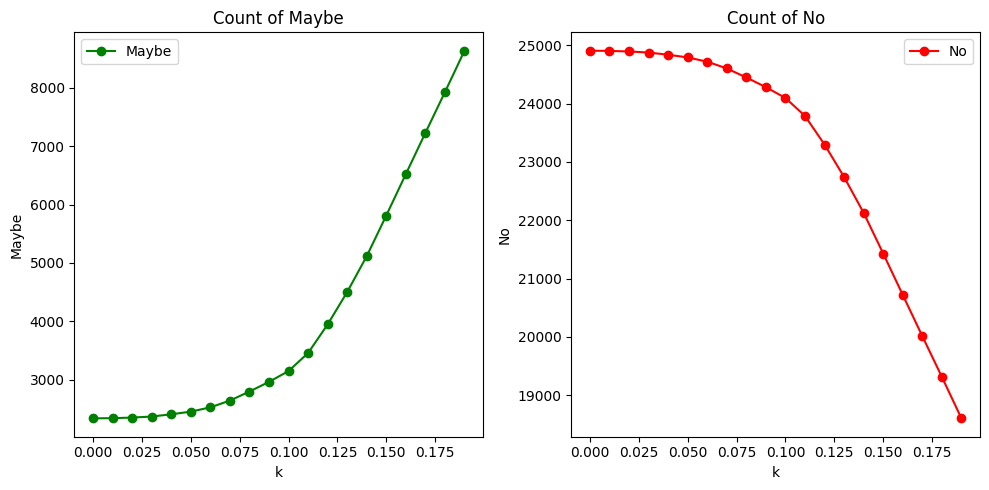

In [53]:
# Initialize an empty list to store the counts for each k
counts_list = []

distances = get_distances(data_important, ['duration', 'day_of_year', 'balance', 'age'], 'y')

for k in np.arange(0, 0.20, 0.01):
  counts = reclassify_data(data_important, distances, k, ['duration', 'day_of_year', 'balance', 'age'], 'maybe')['maybe'].value_counts()

  # Append counts to the list with the value of k
  counts_list.append({'k': k, 'maybe': counts.get(True, 0), 'no': counts.get(False, 0)})

# Convert the list to a dataframe
counts_df = pd.DataFrame(counts_list)

# Plot for 'Maybe'
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(counts_df['k'], counts_df['maybe'], marker='o', linestyle='-', color='g')
plt.xlabel('k')
plt.ylabel('Maybe')
plt.title('Count of Maybe')
plt.legend(['Maybe'])

# Plot for 'No'
plt.subplot(1, 2, 2)
plt.plot(counts_df['k'], counts_df['no'], marker='o', linestyle='-', color='r')
plt.xlabel('k')
plt.ylabel('No')
plt.title('Count of No')
plt.legend(['No'])

plt.tight_layout()
plt.show()

As we increase k, the number of maybes exponentially increase. We have to decide which value of k is beneficial to the bank.

Tradeoff: Higher k likely means better precision, but more calls required since we have more maybes.

We can try Random forest for all discrete values of k in the chart [0, 0.15), and see which ones give the best metrics and weigh it against the number of calls the bank needs to make.



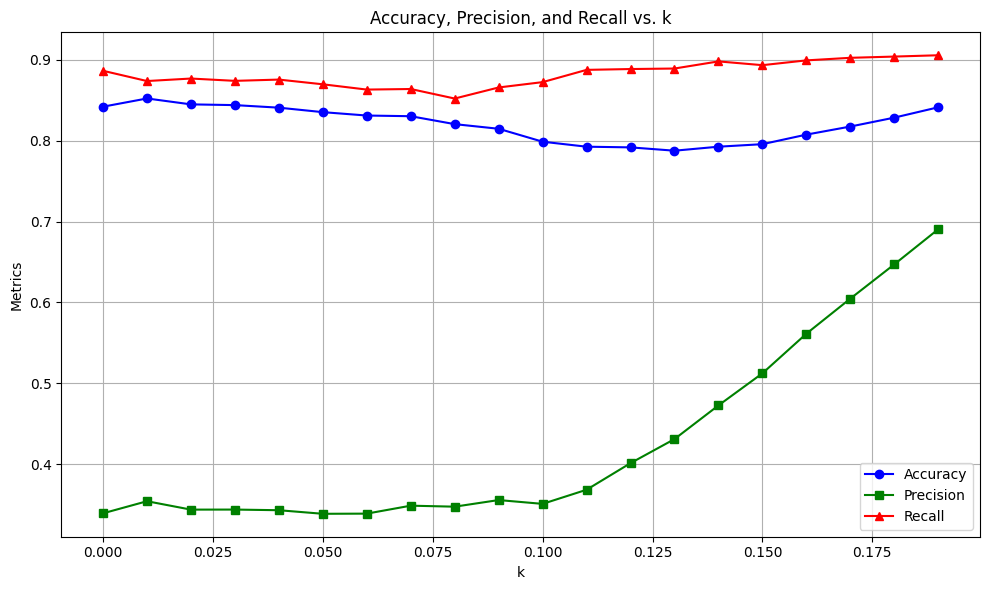

In [54]:
from sklearn.metrics import accuracy_score

accuracies = []
precisions = []
recalls = []
ks = np.arange(0, 0.20, 0.01)

for k in ks:
  data_reclassified = reclassify_data(data_important, distances, k, ['duration', 'day_of_year', 'balance', 'age'], 'maybe')
  X_reclf = data_reclassified.drop('maybe', axis=1)
  y_reclf = data_reclassified['maybe']

  # Define the model
  # heuristic min_samples_leaf=10 to prevent overfiting
  clf = RandomForestClassifier(random_state=42, min_samples_leaf=10)

  # Perform cross-validation and get predictions
  pipeline, y_pred = run_predict(clf, X_reclf, y_reclf, undersample=True)

  report = classification_report(y_reclf, y_pred, output_dict=True)


  # Extract metrics
  accuracy = accuracy_score(y_reclf, y_pred)
  precision = report['True']['precision']  # Adjust 'True' if the positive label is different
  recall = report['True']['recall']  # Adjust 'True' if the positive label is different

  # Append metrics to lists
  accuracies.append(accuracy)
  precisions.append(precision)
  recalls.append(recall)

# Plotting
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(ks, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')

# Plot precision
plt.plot(ks, precisions, marker='s', linestyle='-', color='g', label='Precision')

# Plot recall
plt.plot(ks, recalls, marker='^', linestyle='-', color='r', label='Recall')

# Adding labels and title
plt.xlabel('k')
plt.ylabel('Metrics')
plt.title('Accuracy, Precision, and Recall vs. k')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Observations:


*   k >= 0.15 gives high quality numbers for all three metrics.
*   The higher k the bank picks, the more calls they need to make.



In [55]:
summary = counts_df[counts_df['k'] >= 0.15]

summary['customer_elimination'] = summary['no'] / (summary['no'] + summary['maybe'])
summary['accuracy'] =  accuracies[-len(summary):]
summary['precision'] = precisions[-len(summary):]
summary['recall'] = recalls[-len(summary):]

# Convert values to percentages
summary['customer_elimination'] = summary['customer_elimination'] * 100
summary['accuracy'] = summary['accuracy'] * 100
summary['precision'] = summary['precision'] * 100
summary['recall'] = summary['recall'] * 100

# Optionally format as percentage strings
summary['customer_elimination'] = summary['customer_elimination'].apply(lambda x: f'{x:.2f}%')
summary['accuracy'] = summary['accuracy'].apply(lambda x: f'{x:.2f}%')
summary['precision'] = summary['precision'].apply(lambda x: f'{x:.2f}%')
summary['recall'] = summary['recall'].apply(lambda x: f'{x:.2f}%')

summary

k  maybe     no customer_elimination accuracy precision  recall
15  0.15   5813  21428               78.66%   79.58%    51.23%  89.35%
16  0.16   6523  20718               76.05%   80.76%    56.13%  89.94%
17  0.17   7229  20012               73.46%   81.76%    60.47%  90.26%
18  0.18   7928  19313               70.90%   82.86%    64.71%  90.41%
19  0.19   8638  18603               68.29%   84.14%    69.06%  90.58%

## Summary

To determine which customers from Model 1 to keep on calling:



1.   Drop all features except balance, age, duration, and call date.
2.   Standardize and reclassify each point as a no or maybe, using a distance k between 0.15 and 0.20. Accuracy and recall will always be good regardless of value of k, but to get at least 50% precision, k needs to be at least 0.15.
3. Train a random forest with min_samples_leaf=10 on the reclassified data.

The business value of Model 2 is that it reduces the number of customers predicted by Model 1 by at least 68%.

The tradeoff the bank has to decide between is whether precision or customer elimiation is more important.


# Model 3

Who are the subscribers?

We can use unsupervised techniques on the original dataset (subscribing customers only). This will allow us to look at different groups (clusters) within the customers and find patterns within them.

In [56]:
data.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  duration  campaign   y  day_of_year  
0  unknown       261         1  no          126  
1  unknown       151         1  no          126  
2  unknown        76         1  no          126  
3  unknown        92         1  no          126  
4  unknown       198         1  no          126

## Preprocess

In [57]:
data_m3 = data[data['y'] == 'yes'].drop('y', axis=1)
data_m3.head()

age         job  marital  education default  balance housing loan  \
83    59       admin  married  secondary      no     2343     yes   no   
86    56       admin  married  secondary      no       45      no   no   
87    41  technician  married  secondary      no     1270     yes   no   
129   55    services  married  secondary      no     2476     yes   no   
168   54       admin  married   tertiary      no      184      no   no   

     contact  duration  campaign  day_of_year  
83   unknown      1042         1          126  
86   unknown      1467         1          126  
87   unknown      1389         1          126  
129  unknown       579         1          126  
168  unknown       673         2          126

In [58]:
data_m3.shape

(2896, 12)

In [59]:
binary_features = ['default', 'housing', 'loan']
categorical_features = ['job', 'marital', 'education', 'contact']
numerical_features = ['age', 'balance', 'campaign', 'day_of_year', 'duration']

In [60]:
data_m3 = pd.get_dummies(data_m3.copy(), columns=categorical_features, drop_first=True)
data_m3[binary_features] = data_m3[binary_features].replace({'yes': 1, 'no': 0})
bool_cols = data_m3.select_dtypes(include=['bool']).columns
data_m3[bool_cols] = data_m3[bool_cols].astype(int)
data_m3.head()

age  default  balance  housing  loan  duration  campaign  day_of_year  \
83    59        0     2343        1     0      1042         1          126   
86    56        0       45        0     0      1467         1          126   
87    41        0     1270        1     0      1389         1          126   
129   55        0     2476        1     0       579         1          126   
168   54        0      184        0     0       673         2          126   

     job_blue-collar  job_entrepreneur  ...  job_technician  job_unemployed  \
83                 0                 0  ...               0               0   
86                 0                 0  ...               0               0   
87                 0                 0  ...               1               0   
129                0                 0  ...               0               0   
168                0                 0  ...               0               0   

     job_unknown  marital_married  marital_single  education_secondary  \
83             0                1               0                    1   
86             0                1               0                    1   
87             0                1               0                    1   
129            0                1               0                    1   
168            0                1               0                    0   

     education_tertiary  education_unknown  contact_telephone  contact_unknown  
83                    0                  0                  0                1  
86                    0                  0                  0                1  
87                    0                  0                  0                1  
129                   0                  0                  0                1  
168                   1                  0                  0                1  

[5 rows x 26 columns]

In [61]:
data_m3.shape

(2896, 26)

We need to scale the numerical features so the clustering results aren't biased towards the numerical features (which are much greater than the rest of the features, which are 0/1)

In [62]:
scaler = StandardScaler()
data_m3[numerical_features] = scaler.fit_transform(data_m3[numerical_features])
data_m3.head()

age  default   balance  housing  loan  duration  campaign  \
83   1.741354        0  0.258004        1     0  0.832632 -0.613443   
86   1.468629        0 -0.527801        0     0  1.818224 -0.613443   
87   0.105003        0 -0.108910        1     0  1.637339 -0.613443   
129  1.377720        0  0.303484        1     0 -0.241084 -0.613443   
168  1.286812        0 -0.480270        0     0 -0.023094 -0.179720   

     day_of_year  job_blue-collar  job_entrepreneur  ...  job_technician  \
83     -0.422531                0                 0  ...               0   
86     -0.422531                0                 0  ...               0   
87     -0.422531                0                 0  ...               1   
129    -0.422531                0                 0  ...               0   
168    -0.422531                0                 0  ...               0   

     job_unemployed  job_unknown  marital_married  marital_single  \
83                0            0                1               0   
86                0            0                1               0   
87                0            0                1               0   
129               0            0                1               0   
168               0            0                1               0   

     education_secondary  education_tertiary  education_unknown  \
83                     1                   0                  0   
86                     1                   0                  0   
87                     1                   0                  0   
129                    1                   0                  0   
168                    0                   1                  0   

     contact_telephone  contact_unknown  
83                   0                1  
86                   0                1  
87                   0                1  
129                  0                1  
168                  0                1  

[5 rows x 26 columns]

## K Means



*   Partition data into k clusters based on feature similarity
* Identify groups of subscribing customers, and compare them



In [63]:
from sklearn.cluster import KMeans

# List to hold the inertia values for each k
inertia = []

# Try different values of k (number of clusters)
k_values = range(1, 11)  # Testing k from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_m3)
    inertia.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

k = 6 is the elbow, where reduction in inertia significantly decreases.

In [64]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def k_means_plot(df, k):
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(df)

    # Print counts of each cluster
    cluster_counts = pd.Series(clusters).value_counts()
    print("Cluster counts:")
    for cluster, count in cluster_counts.items():
        print(f"Cluster {cluster}: {count} samples")

    # Reduce dimensionality to 3D using PCA
    pca = PCA(n_components=3)
    data_pca = pca.fit_transform(df)

    # Create a DataFrame for plotting
    df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2', 'PC3'])
    df_pca['Cluster'] = clusters

    # Plotting
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot
    scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=df_pca['Cluster'], cmap='tab10')

    # Adding labels and title
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title(f'K-Means Clustering with k={k} and PCA Reduction')

    # Create custom legend
    handles, labels = scatter.legend_elements(prop="colors")
    ax.legend(handles, [f'Cluster {i}' for i in range(k)], title='Clusters', loc='best')


    plt.show()

Cluster counts:
Cluster 0: 1050 samples
Cluster 3: 568 samples
Cluster 5: 540 samples
Cluster 2: 483 samples
Cluster 1: 171 samples
Cluster 4: 84 samples


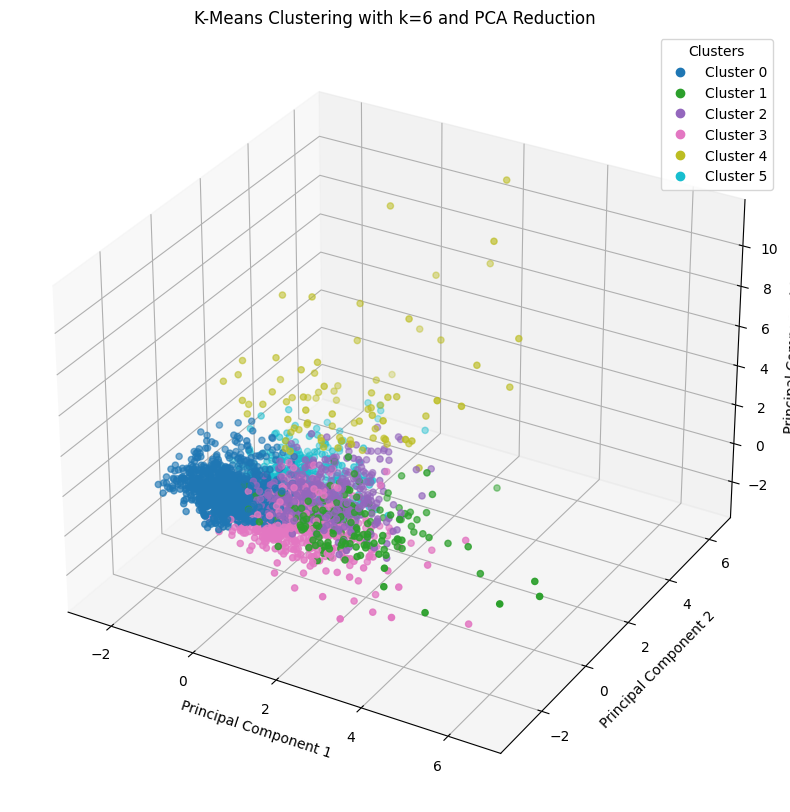

In [65]:
k_means_plot(data_m3, k=6)

Observations:


*  Many clusters are sparse.
* k = 6 not a good clustering



## TSNE



*   Reduces data to 2 or 3 dimensions (we'll use 2 for easy visualization).
*   Gives idea on whether points will form clusters well.
* Preserves distance between data for each cluster, but not distance between the clusters (local structure only)



In [66]:
from sklearn.manifold import TSNE

def tsne_plot(data, perplexity=30):
    # Initialize t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)

    # Fit and transform the data
    data_m3_tsne = tsne.fit_transform(data_m3)

    # Convert the result to a DataFrame
    data_m3_tsne_df = pd.DataFrame(data_m3_tsne, columns=['Dimension 1', 'Dimension 2'])

    # Optional: Plot the 2D scatter plot
    plt.figure(figsize=(10, 7))
    plt.scatter(data_m3_tsne_df['Dimension 1'], data_m3_tsne_df['Dimension 2'], alpha=0.7)
    plt.title('t-SNE Projection to 2 Dimensions')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

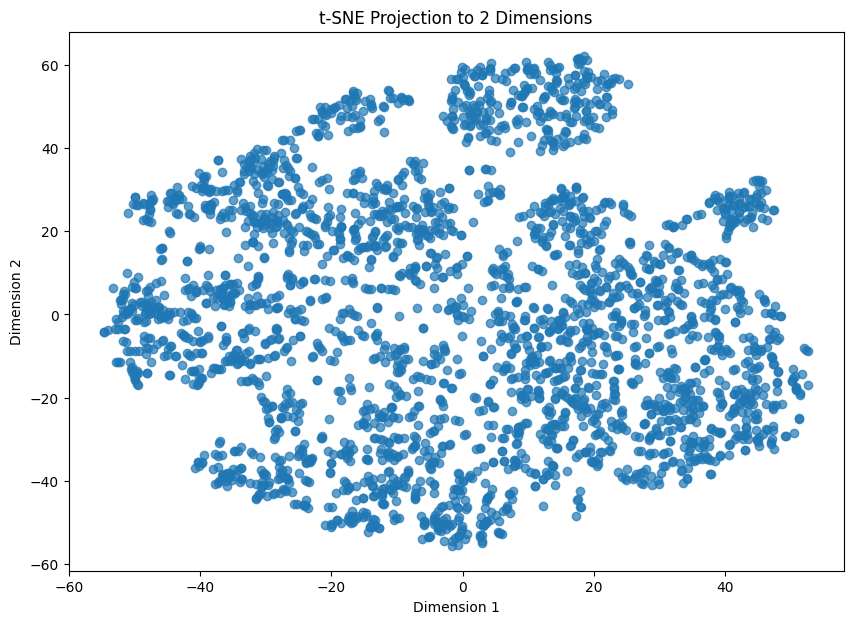

In [67]:
tsne_plot(data_m3)

Observations:


*   No clear cluster separation or structure


### Perplexity

Perplexity is the number of neighbors that is considered when computing similarity between data points. The default perplexity (as used in the previous plot) is 30. Common values tested are from 5 to 50.

Low perplexity considers a small neighborhood, prioritizing similarity of data points that are close to each other. High perplexity considers large neighborhood, capturing broader patterns, but less finer detail within smaller areas.

We will use smaller values, because we care more about how the points group than the relative distance between the groups.


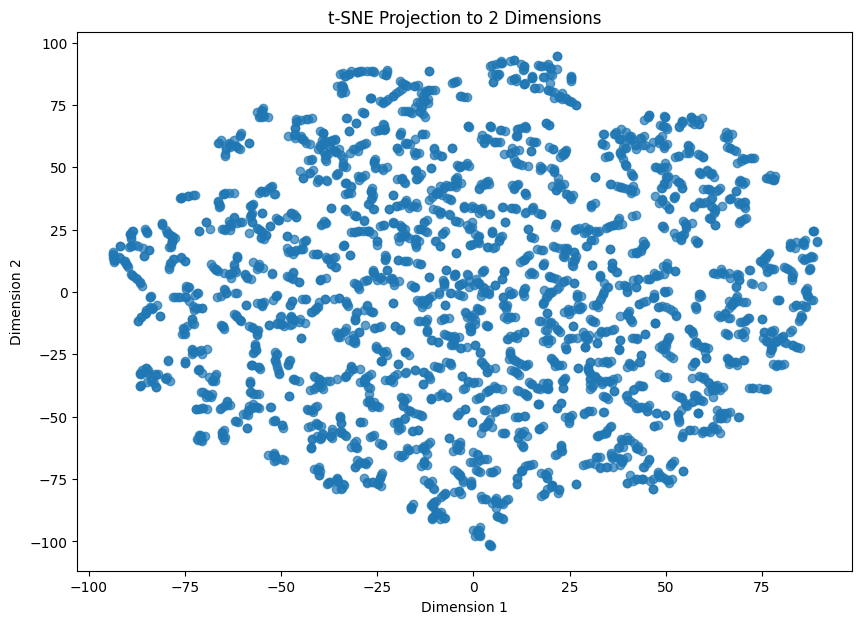

In [68]:
tsne_plot(data_m3, perplexity=5)

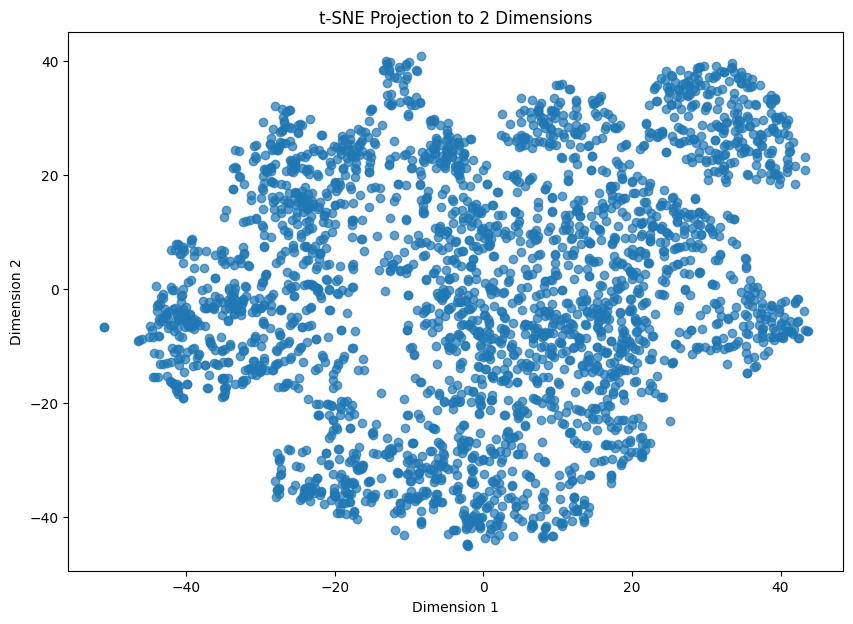

In [69]:
tsne_plot(data_m3, perplexity=50)

Observations:


*   Low and high perplexities don't capture well-defined, meaningful clusters.



## UMAP


*   Same objective as TSNE
*   Preserves local and global structure (distnaces between potential clusters).



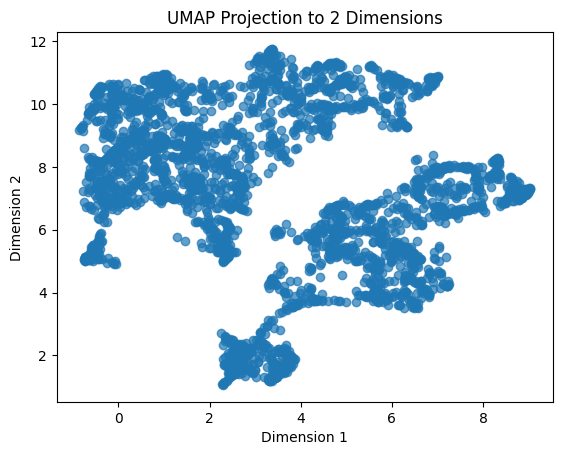

In [70]:
import umap

# Initialize UMAP for 2 dimensions
umap_model = umap.UMAP(n_components=2, random_state=42)

# Fit and transform the data
umap_m3 = umap_model.fit_transform(data_m3)

# Create a DataFrame for the UMAP result
df_umap = pd.DataFrame(umap_m3, columns=['Dimension 1', 'Dimension 2'])

plt.scatter(df_umap['Dimension 1'], df_umap['Dimension 2'], alpha=0.7)
plt.title('UMAP Projection to 2 Dimensions')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

Observations:



*   Points group better and more densely than with TSNE.
*   Two to 5 dense clusters. Let's try k = 2 through 5.



## K means part 2

In [71]:
data_m3.head()

age  default   balance  housing  loan  duration  campaign  \
83   1.741354        0  0.258004        1     0  0.832632 -0.613443   
86   1.468629        0 -0.527801        0     0  1.818224 -0.613443   
87   0.105003        0 -0.108910        1     0  1.637339 -0.613443   
129  1.377720        0  0.303484        1     0 -0.241084 -0.613443   
168  1.286812        0 -0.480270        0     0 -0.023094 -0.179720   

     day_of_year  job_blue-collar  job_entrepreneur  ...  job_technician  \
83     -0.422531                0                 0  ...               0   
86     -0.422531                0                 0  ...               0   
87     -0.422531                0                 0  ...               1   
129    -0.422531                0                 0  ...               0   
168    -0.422531                0                 0  ...               0   

     job_unemployed  job_unknown  marital_married  marital_single  \
83                0            0                1               0   
86                0            0                1               0   
87                0            0                1               0   
129               0            0                1               0   
168               0            0                1               0   

     education_secondary  education_tertiary  education_unknown  \
83                     1                   0                  0   
86                     1                   0                  0   
87                     1                   0                  0   
129                    1                   0                  0   
168                    0                   1                  0   

     contact_telephone  contact_unknown  
83                   0                1  
86                   0                1  
87                   0                1  
129                  0                1  
168                  0                1  

[5 rows x 26 columns]

In [72]:
k_means_plot(data_m3, k=2)

Cluster counts:
Cluster 0: 1635 samples
Cluster 1: 1261 samples


Cluster counts:
Cluster 1: 1304 samples
Cluster 2: 954 samples
Cluster 0: 638 samples


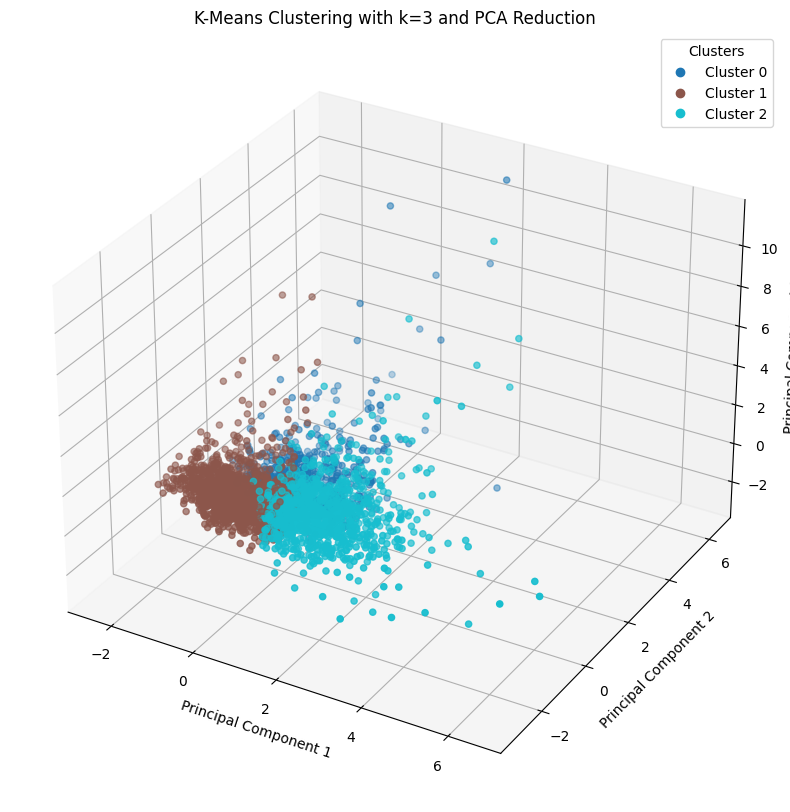

In [73]:
k_means_plot(data_m3, k=3)

Cluster counts:
Cluster 0: 1192 samples
Cluster 1: 963 samples
Cluster 2: 628 samples
Cluster 3: 113 samples


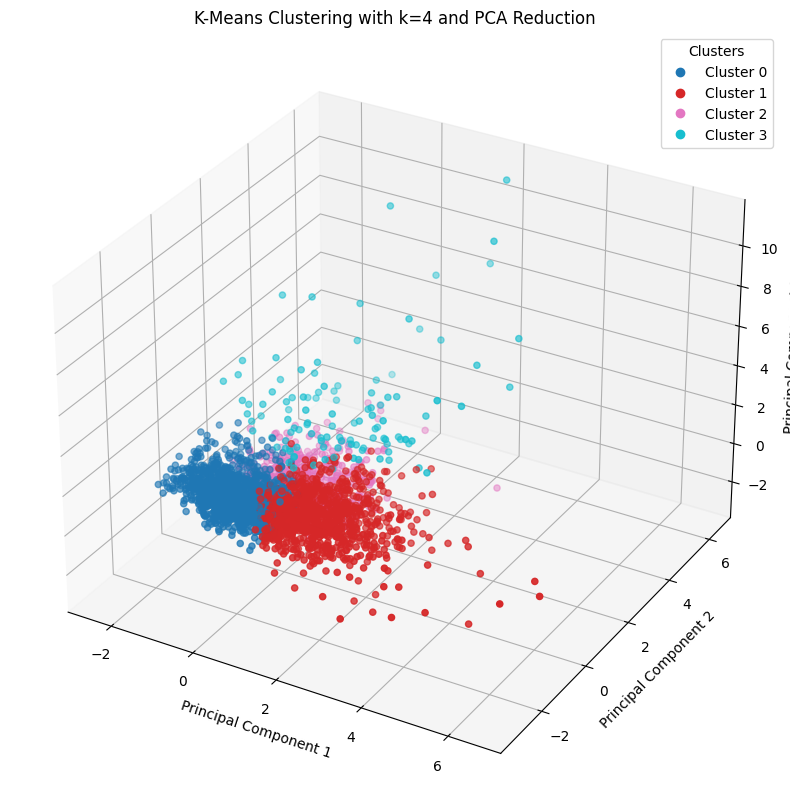

In [74]:
k_means_plot(data_m3, k=4)

In [75]:
k_means_plot(data_m3, k=5)

Cluster counts:
Cluster 2: 1120 samples
Cluster 0: 905 samples
Cluster 4: 601 samples
Cluster 1: 170 samples
Cluster 3: 100 samples


Observations:

k=4 is the best clustering because:
*   It has the most number of dense, non-overlapping/barely-overlapping (hard to see in 3d though) clusters (0, 1, 2)
*   Cluster 3 is sparse, but very few points (113, about 4%) are in it.

We can verify the strength of each cluster by making sure that the feature values that contibute to them are distinct enough.

Also, this clustering adds business value because there are 3 likely distinct groups of subscribers, and the fourth one (cluster 3) could give some insights as to why a group of customers are all over the place (perhaps outliers?).



## 4-Means

Do algorithm to attach cluster labels to each row.

In [76]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_m3)
data_m3['cluster'] = clusters
data_m3.head()

age  default   balance  housing  loan  duration  campaign  \
83   1.741354        0  0.258004        1     0  0.832632 -0.613443   
86   1.468629        0 -0.527801        0     0  1.818224 -0.613443   
87   0.105003        0 -0.108910        1     0  1.637339 -0.613443   
129  1.377720        0  0.303484        1     0 -0.241084 -0.613443   
168  1.286812        0 -0.480270        0     0 -0.023094 -0.179720   

     day_of_year  job_blue-collar  job_entrepreneur  ...  job_unemployed  \
83     -0.422531                0                 0  ...               0   
86     -0.422531                0                 0  ...               0   
87     -0.422531                0                 0  ...               0   
129    -0.422531                0                 0  ...               0   
168    -0.422531                0                 0  ...               0   

     job_unknown  marital_married  marital_single  education_secondary  \
83             0                1               0                    1   
86             0                1               0                    1   
87             0                1               0                    1   
129            0                1               0                    1   
168            0                1               0                    0   

     education_tertiary  education_unknown  contact_telephone  \
83                    0                  0                  0   
86                    0                  0                  0   
87                    0                  0                  0   
129                   0                  0                  0   
168                   1                  0                  0   

     contact_unknown  cluster  
83                 1        2  
86                 1        2  
87                 1        1  
129                1        2  
168                1        2  

[5 rows x 27 columns]

### Binary Features

In [77]:
# Analyze original binary features (default, housing, loan)
data_m3_binary = data_m3[['default', 'housing', 'loan', 'cluster']].groupby('cluster')
centroids_binary = data_m3_binary.mean()
centroids_binary

default   housing      loan
cluster                              
0        0.019295  0.580537  0.115772
1        0.017653  0.501558  0.170301
2        0.014331  0.385350  0.113057
3        0.000000  0.415929  0.061947

Observations:

*   Clusters 0 (dense) and 1 (dense) have above 50% of the customers with a home loan.
* Clusters 2 (dense) and 3 (sparse) have under 50% of the customers with a home loan.
* Rest of features are minority for each cluster. Not helpful for distinguishing clusters.

### Categorical Features

Once we reverse the one hot encoding, we can get pie charts for each feature.

In [78]:
# Define the prefixes for the one-hot encoded columns
prefixes = {
    'job': 'job_',
    'education': 'education_',
    'marital': 'marital_',
    'contact': 'contact_'
}

# Function to reverse one-hot encoding for a given prefix
def reverse_one_hot_encoding(df, prefix, original_column):
    # Find columns that start with the prefix
    one_hot_columns = [col for col in df.columns if col.startswith(prefix)]

    if one_hot_columns:
        # Extract the original category column
        df[original_column] = df[one_hot_columns].idxmax(axis=1).str.replace(prefix, '')
        # Drop the one-hot encoded columns
        df = df.drop(columns=one_hot_columns)

    return df

# Apply the function for each prefix
for original_column, prefix in prefixes.items():
    data_m3 = reverse_one_hot_encoding(data_m3, prefix, original_column)

data_m3.head()

age  default   balance  housing  loan  duration  campaign  \
83   1.741354        0  0.258004        1     0  0.832632 -0.613443   
86   1.468629        0 -0.527801        0     0  1.818224 -0.613443   
87   0.105003        0 -0.108910        1     0  1.637339 -0.613443   
129  1.377720        0  0.303484        1     0 -0.241084 -0.613443   
168  1.286812        0 -0.480270        0     0 -0.023094 -0.179720   

     day_of_year  cluster          job  education  marital  contact  
83     -0.422531        2  blue-collar  secondary  married  unknown  
86     -0.422531        2  blue-collar  secondary  married  unknown  
87     -0.422531        1   technician  secondary  married  unknown  
129    -0.422531        2     services  secondary  married  unknown  
168    -0.422531        2  blue-collar   tertiary  married  unknown

In [79]:
categorical_features = ['job', 'education', 'marital', 'contact']
clusters = sorted(data_m3['cluster'].unique())  # Ensure clusters are sorted

# Create a figure with subplots
fig, axes = plt.subplots(len(clusters), len(categorical_features), figsize=(15, 10))

# Group by cluster once
grouped = data_m3.groupby('cluster')

for i, cluster in enumerate(clusters):
    for j, feature in enumerate(categorical_features):
        ax = axes[i, j]
        # Calculate the value counts for the feature in the current cluster
        feature_counts = grouped.get_group(cluster)[feature].value_counts()
        ax.pie(feature_counts, labels=feature_counts.index, autopct='%1.1f%%', startangle=140)
        ax.set_title(f'{feature} - Cluster {cluster}')

# Adjust layout
plt.tight_layout()
plt.show()

Observations:

*   Jobs:

Top 3 for Clusters 0 (dense) and 1 (dense) are Blue Collar, Management and Technician. Roughly in same proprotions.

Top 3 for Cluster 2 (dense) is Blue Collar, Retired, Management.

Top 3 for Cluster 3 (sparse) is Management, Blue Collar, Technician. Management has WAY higher proportion than the next two.

* Marital

Majority is single for Cluster 0.

Super majority is married for Clusters 1 and 2

Majority is married for Cluster 3.




*   Education

Majority has secondary education for Clusters 0, 1, 2 (roughly same proportions for all 3 categories).

About even representation of tertiary and secondary for Cluster 3.


* Contact

All Clusters have majority telephone info. Not useful in distinguishing clusters.




### Numerical Features

First, we need box plots for each numerical feature, while they are still scaled.

In [80]:
data_m3.head()

age  default   balance  housing  loan  duration  campaign  \
83   1.741354        0  0.258004        1     0  0.832632 -0.613443   
86   1.468629        0 -0.527801        0     0  1.818224 -0.613443   
87   0.105003        0 -0.108910        1     0  1.637339 -0.613443   
129  1.377720        0  0.303484        1     0 -0.241084 -0.613443   
168  1.286812        0 -0.480270        0     0 -0.023094 -0.179720   

     day_of_year  cluster          job  education  marital  contact  
83     -0.422531        2  blue-collar  secondary  married  unknown  
86     -0.422531        2  blue-collar  secondary  married  unknown  
87     -0.422531        1   technician  secondary  married  unknown  
129    -0.422531        2     services  secondary  married  unknown  
168    -0.422531        2  blue-collar   tertiary  married  unknown

In [81]:
features = ['age', 'balance', 'campaign', 'day_of_year', 'duration', 'cluster']
data_m3_numerical_scaled = data_m3[features]
data_m3_numerical_scaled.head()


age   balance  campaign  day_of_year  duration  cluster
83   1.741354  0.258004 -0.613443    -0.422531  0.832632        2
86   1.468629 -0.527801 -0.613443    -0.422531  1.818224        2
87   0.105003 -0.108910 -0.613443    -0.422531  1.637339        1
129  1.377720  0.303484 -0.613443    -0.422531 -0.241084        2
168  1.286812 -0.480270 -0.179720    -0.422531 -0.023094        2

In [82]:
# Melt the DataFrame to long format for Seaborn
data_melted = pd.melt(data_m3_numerical_scaled, id_vars='cluster', var_name='feature', value_name='value')

# Create boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(x='feature', y='value', hue='cluster', data=data_melted, palette='Set2')

# Add title and labels
plt.xlabel('Feature')
plt.ylabel('Value')

# Show the plot
plt.legend(title='Cluster')
plt.show()

Observations (in terms of Q1 through Q3):


*   age(cluster 0) < age(cluster 1) < age(cluster 2) (general trend, not strict).
*   age(cluster 3) tends to be less than age(cluster 2).


* balance(cluster 3) tends to be well above the rest of the clusters.
* balance of clusters 0, 1, 2 have about same 25th percentile, and their 75th percentiles slightly increase from 0 to 2.


* campaign, day of year, and duration for cluster 1 tends to be greater than the rest of the clusters, which have pretty good overlap.


We should explore specific age and balance values for all the clusters, and specific campaign, day of year and duration values for cluster 1.


In [83]:
features.remove('cluster')
data_m3_numerical_scaled = data_m3_numerical_scaled[features]

# Use scaler from initial preprocessing to unscale
unstandardized_data = scaler.inverse_transform(data_m3_numerical_scaled)

# Create a DataFrame with the unscaled data and preserve the original index
data_m3_numerical = pd.DataFrame(unstandardized_data, columns=features, index=data_m3.index)

# Add the cluster column to the unscaled DataFrame
data_m3_numerical['cluster'] = data_m3['cluster'].values
data_m3_numerical.head()

age  balance  campaign  day_of_year  duration  cluster
83   59.0   2343.0       1.0        126.0    1042.0        2
86   56.0     45.0       1.0        126.0    1467.0        2
87   41.0   1270.0       1.0        126.0    1389.0        1
129  55.0   2476.0       1.0        126.0     579.0        2
168  54.0    184.0       2.0        126.0     673.0        2

In [84]:
# Define a function to compute Q1, Q2, Q3, and standard deviation
def compute_feature_stats(group):
    return pd.Series({
        'Q1': group.quantile(0.25),
        'Q2': group.median(),
        'Q3': group.quantile(0.75),
        'std': group.std()
    })

# Create separate DataFrames for each feature
feature_dfs = {}
for feature in features:
    # Group by 'cluster' and calculate Q1, Q2 (median), Q3, and standard deviation for each feature
    feature_df = data_m3_numerical.groupby('cluster')[feature].apply(compute_feature_stats).unstack().reset_index()
    feature_dfs[feature] = feature_df

# Display the results
for feature, df in feature_dfs.items():
    print(f"Statistics for {feature}:")
    print(df, "\n")

Statistics for age:
   cluster    Q1    Q2    Q3        std
0        0  28.0  32.0  36.0   5.298027
1        1  33.0  39.0  45.0   7.953484
2        2  48.0  53.5  59.0   8.224671
3        3  32.0  39.0  50.0  11.483677 

Statistics for balance:
   cluster       Q1       Q2        Q3          std
0        0   118.75    483.5   1247.00  1335.720589
1        1   116.50    560.0   1627.50  1552.995736
2        2   190.75    804.0   2256.25  1764.458686
3        3  8163.00  10252.0  13094.00  6528.787739 

Statistics for campaign:
   cluster   Q1   Q2   Q3       std
0        0  1.0  1.0  2.0  1.153489
1        1  2.0  3.0  4.0  3.232963
2        2  1.0  1.0  2.0  1.388833
3        3  1.0  2.0  3.0  2.437525 

Statistics for day_of_year:
   cluster     Q1     Q2     Q3        std
0        0  103.0  127.0  143.0  44.312438
1        1  171.5  212.0  240.0  65.808823
2        2  105.0  128.0  155.0  58.090064
3        3  113.0  147.0  227.0  92.194841 

Statistics for duration:
   cluster     

## Profiles of our Customers

Here is a summary of each cluster (group of customers). This summary reports significant differences that distingush the clusters. Each numerical feature is reported as its 25th to 75th percentile:

Cluster 0: 1192 samples
Cluster 1: 963 samples
Cluster 2: 628 samples
Cluster 3: 113 samples

Cluster 0 (41% of subscribers):


*   Young folks (28-36)
* Mostly Single
* Tend to have home loan

Cluster 1 (33% of subscribers):

* Middle age folks (33-45)
* More times contacted (campaign) and longer duration of call.
* Tend have home loan
* Mostly married

Cluster 2 (21% of subscribers):
* Older folks (48-59)
* Tend to not have home loan
* Includes many retirees
* Mostly married

Cluster 3 (5% of subscribers):
* Middle age folks (32-50).
* RICH (higher bank balance than other groups)
* Tend to not have home loan.
* Mostly Married
* Much more tertiary education than other groups.
* Much higher variance than other groups.

This analysis supports there existing four different groups of subscribing customers. 3 are based on age/stage of life, and the fourth tends to have richer people.


## Recommendations



*   Reduce marketing efforts to cluster 3 (rich people). They only make 5% of the subscriber base, and the variance is too high to make any meaningful conclusions about them.
*   Increase marketing efforts to clusters 0, 1, 2 (different ages/stages of life with similar balances). They each make meaningful proportions of the subscriber base.



# Dashboard

Optionally run following cells to export data_m3 (subscriber profiles) to use in dashboard.

In [85]:
# Convert binary columns to 'no'/'yes'
binary_columns = ['default', 'housing', 'loan']  # List of binary columns to convert

for col in binary_columns:
    data_m3[col] = data_m3[col].replace({0: 'no', 1: 'yes'})

In [86]:
# unstandardize numerical features
data_m3[features] = data_m3_numerical[features]
data_m3['cluster'] = data_m3_numerical['cluster']
data_m3.head()

age default  balance housing loan  duration  campaign  day_of_year  \
83   59.0      no   2343.0     yes   no    1042.0       1.0        126.0   
86   56.0      no     45.0      no   no    1467.0       1.0        126.0   
87   41.0      no   1270.0     yes   no    1389.0       1.0        126.0   
129  55.0      no   2476.0     yes   no     579.0       1.0        126.0   
168  54.0      no    184.0      no   no     673.0       2.0        126.0   

     cluster          job  education  marital  contact  
83         2  blue-collar  secondary  married  unknown  
86         2  blue-collar  secondary  married  unknown  
87         1   technician  secondary  married  unknown  
129        2     services  secondary  married  unknown  
168        2  blue-collar   tertiary  married  unknown

In [88]:
data_m3.to_csv('subscribers.csv', index=False)